In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from google.colab import files 
import io

In [4]:
data=pd.read_csv('G:/WhiteWine.csv')
data

,date,RelativeInterest
0,2010-01,54
1,2010-02,54
2,2010-03,58
3,2010-04,52
4,2010-05,61
...,...,...
67,2015-08,81
68,2015-09,72
69,2015-10,70
70,2015-11,83


In [5]:
data.RelativeInterest




0      54
1      54
2      58
3      52
4      61
     ... 
67     81
68     72
69     70
70     83
71    100
Name: RelativeInterest, Length: 72, dtype: int64

In [6]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data.RelativeInterest.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.620020
p-value: 0.472719


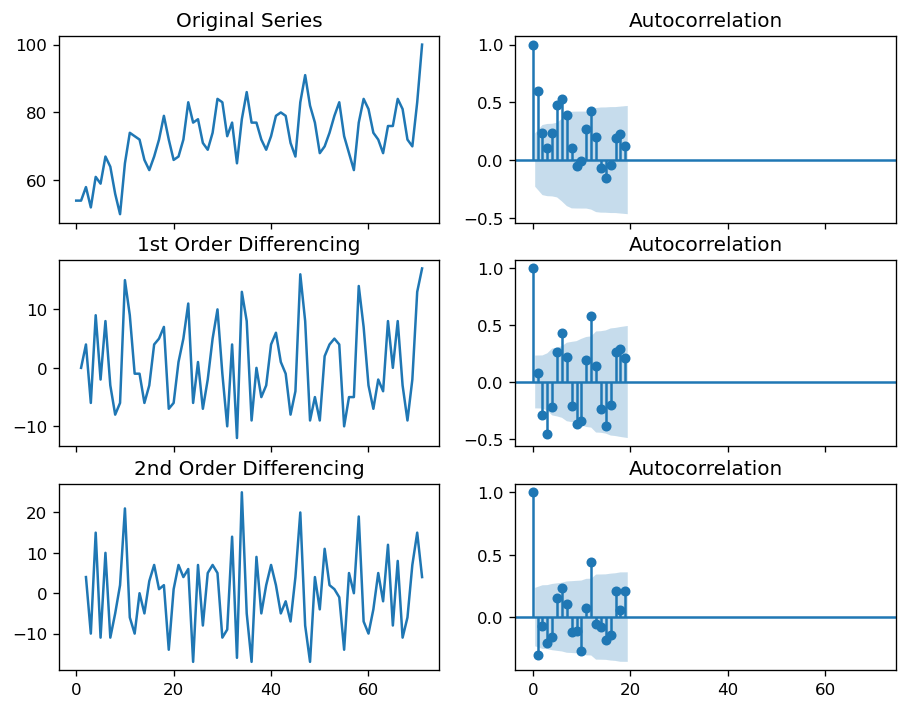

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data.RelativeInterest); axes[0, 0].set_title('Original Series')
plot_acf(data.RelativeInterest, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.RelativeInterest.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.RelativeInterest.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.RelativeInterest.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.RelativeInterest.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

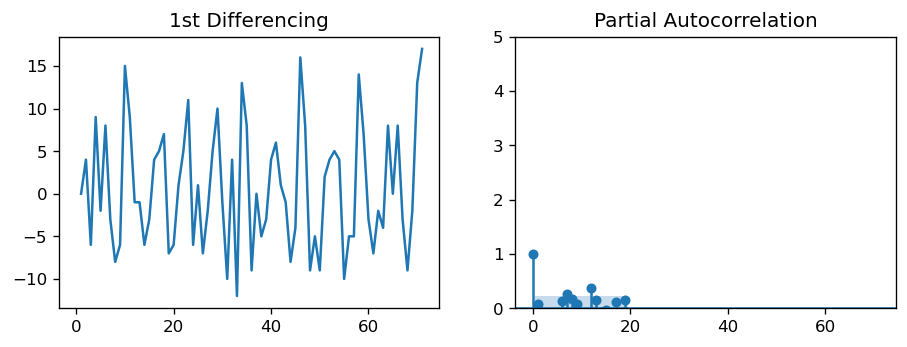

In [8]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.RelativeInterest.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.RelativeInterest.diff().dropna(), ax=axes[1])

plt.show()

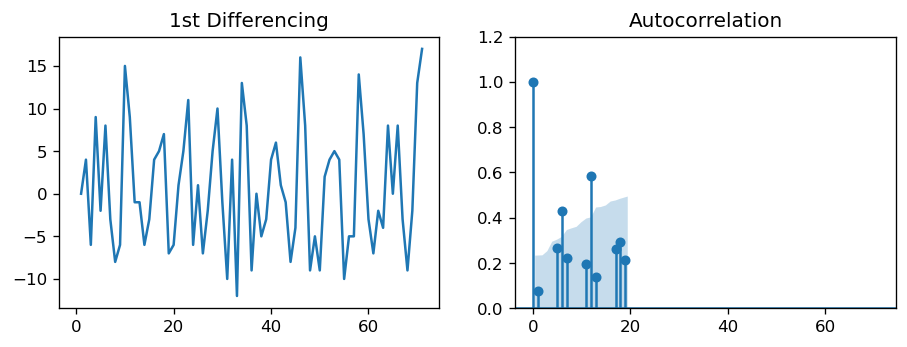

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.RelativeInterest.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data.RelativeInterest.diff().dropna(), ax=axes[1])

plt.show()

In [11]:
import warnings

warnings.filterwarnings("ignore")
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(data.RelativeInterest, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:     D.RelativeInterest   No. Observations:                   71
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -233.822
Method:                       css-mle   S.D. of innovations              6.378
Date:                Sun, 06 Nov 2022   AIC                            475.644
Time:                        22:30:49   BIC                            484.695
Sample:                             1   HQIC                           479.243
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.2972      0.079      3.753      0.000       0.142       0.452
ar.L1.D.RelativeInterest     0.5574      0.110      5.072      0.000       0.342       0.

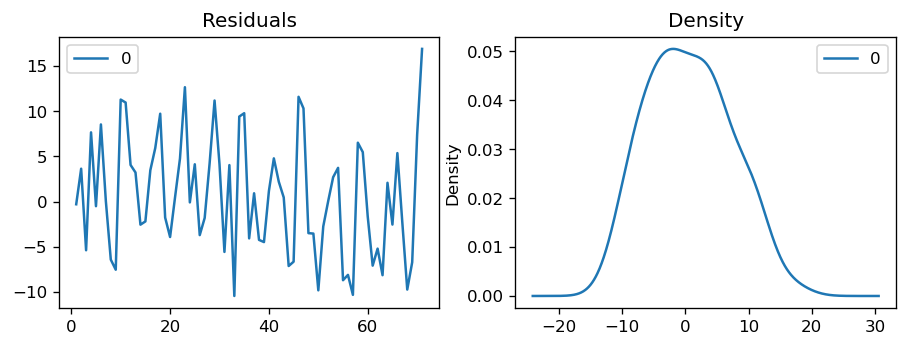

In [12]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

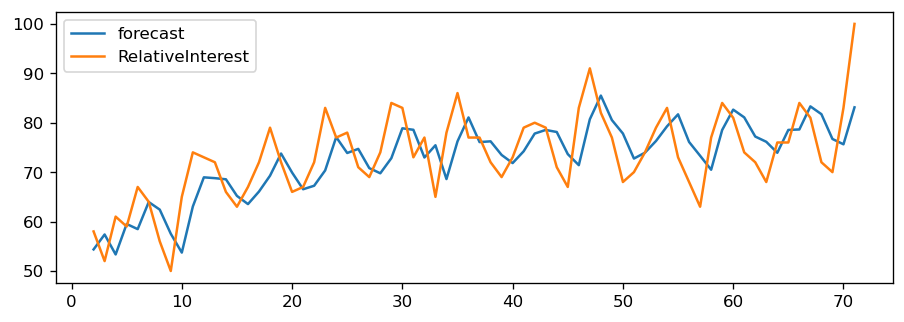

In [13]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [17]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = data.RelativeInterest[:35]
test = data.RelativeInterest[35:]

In [18]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(3,2,1))  
fitted = model.fit()  

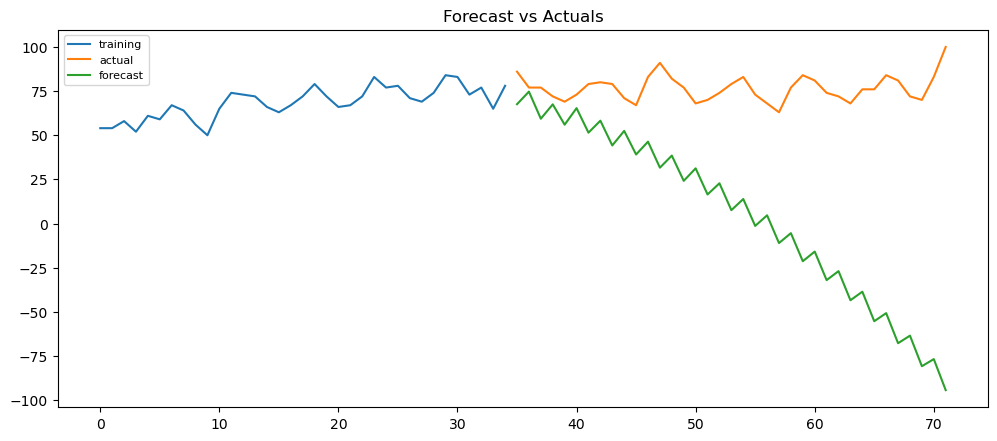

In [19]:
fc, se, conf = fitted.forecast(37, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(37, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [20]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.9266560800746596,
 'me': -71.6529795145713,
 'mae': 71.6529795145713,
 'mpe': -0.9266560800746596,
 'rmse': 87.23086979329047,
 'acf1': 0.8640895085068998,
 'corr': -0.1493918453980072,
 'minmax': 0.9266560800746597}

In [21]:
!pip install pmdarima

  Using cached numpy-1.23.4-cp39-cp39-win_amd64.whl (14.7 MB)


ERROR: Exception:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 462, in read
    n = self.readinto(b)
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 506, in readinto
    n = self.fp.readinto(b)
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\ProgramData\Anaconda3\lib\ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "C:\ProgramData\Anaconda3\lib\ssl.py", line 1099, in read
    return self._sslobj.read(len, buffer)
soc